In [ ]:
# install dependencies for TensorFlow Federated and asyncio
# tensorflow federated 0.20.0 is the last version which supports python 3.7 (python version in colab)
# tensorflow probability 0.16.0 is currently needed for compatibility reasons
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet tensorflow-probability==0.16.0

     |████████████████████████████████| 819 kB 4.8 MB/s 
     |████████████████████████████████| 45 kB 4.5 MB/s 
     |████████████████████████████████| 65.2 MB 1.2 MB/s 
     |████████████████████████████████| 126 kB 52.1 MB/s 
     |████████████████████████████████| 120 kB 62.4 MB/s 
     |████████████████████████████████| 238 kB 77.5 MB/s 
     |████████████████████████████████| 251 kB 79.8 MB/s 
     |████████████████████████████████| 887 kB 72.5 MB/s 
     |████████████████████████████████| 4.0 MB 68.3 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
     |████████████████████████████████| 498.0 MB 11 kB/s 
     |████████████████████████████████| 462 kB 61.1 MB/s 
     |████████████████████████████████| 1.4 MB 60.5 MB/s 
     |████████████████████████████████| 5.8 MB 81.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.4 requir

In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print('GPU:',gpu_info[599:619])
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

GPU: Tesla T4            
Your runtime has 13.6 gigabytes of available RAM


In [ ]:
!pip install -q tqdm>=4.36.1

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import models, layers, metrics
from keras.metrics import BinaryAccuracy, RootMeanSquaredError #, Precision, Recall
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
# drive.mount('/content/drive')

ImportError: ignored

In [ ]:
np.random.seed(0)

Downloading SynCAN dataset to local directory

In [ ]:
!git clone https://github.com/etas/SynCAN.git &> /dev/null
!unzip ./SynCAN/\*.zip -d ./SynCAN/. &> /dev/null
!rm ./SynCAN/*.zip &> /dev/null

Preparing dataset by converting csv file to pandas dataframe

In [ ]:
TIME_STEPS = 20
NUM_IDS = 1
MSG_IDS = ['id'+str(i+1) for i in range(NUM_IDS)] # ["id1", "id2",...."id10"]
ID_INPUT_DIMS = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4] # respective number of signals used by each ID
TITLES_OF_IDS = []
for dim in ID_INPUT_DIMS:
    TITLES_OF_IDS.append(["Signal"+str(i+1) for i in range(dim)])
LSTM_INPUT_UNITS = 64
LSTM_OUTPUT_UNITS = 64

def csv2df(dir_path):
    data_frames = []
    csv_path = dir_path + "/train_1.csv"    # train 1 contains header
    df_temp = pd.read_csv(csv_path)
    data_frames.append(df_temp)
    for i in range(2, 5):
        csv_path = dir_path + "/train_" + str(i) + ".csv"
        df_temp = pd.read_csv(csv_path, header=None, names=["Label",  "Time",
                                                            "ID", "Signal1",
                                                            "Signal2",  "Signal3",
                                                            "Signal4"])
        data_frames.append(df_temp)
    df = pd.concat(data_frames)
    return df

def prepare_dataset():
    # convert csv and standardize features
    df = csv2df("/content/SynCAN")
    dfMap = {}
    for i in range(NUM_IDS):
        df_for_Id = df[:][df.ID==MSG_IDS[i]]
        df_for_Id = df_for_Id.dropna(axis=1,how='all')
        df_labels = df_for_Id.iloc[:,0:2]
        df_for_Id = df_for_Id.iloc[:,3:len(df_for_Id.columns)]
        training_mean = df_for_Id.mean()
        training_std = df_for_Id.std()
        data_set_standardized = (df_for_Id - training_mean) / training_std
        dfMap["id" + str(i+1)] = df_labels.join(data_set_standardized)
    return dfMap

def create_sequences(values, time_steps, stride=1, trunc_length=None):
    if not trunc_length:
        trunc_length = len(values)
    sequences = []
    for i in range(0, num_samples, stride):
        if (i+time_steps) <= len(values):
            sequences.append(values[i:(i+time_steps)])
    return np.stack(sequences)

Verifying number of dataframes and their sizes

In [ ]:
def show_raw_visualization(idx, __df_map, data_length):
    message_id = MSG_IDS[idx]
    data = __df_map[message_id].iloc[:data_length].copy()
    data["time"] = data.index
    titles = TITLES_OF_IDS[idx]
    colors = [
        "blue",
        "orange",
        "green",
        "red"
    ]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(10, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(titles)):
        key = titles[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = list(range(data_length))
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(titles[i]+ "_ID"+str(idx+1)),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

id1 original data shape: (5874013, 4)


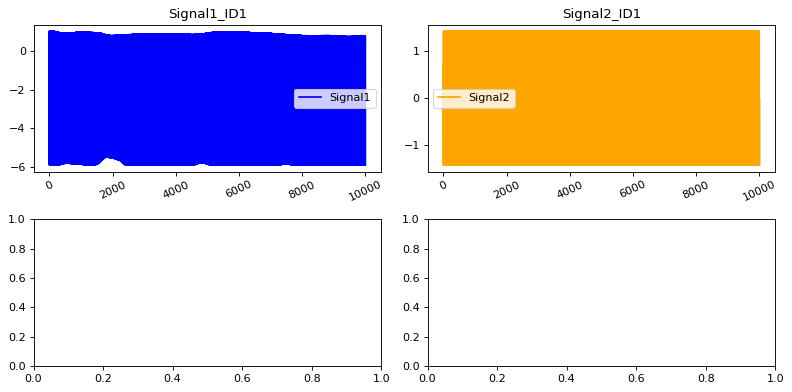

In [ ]:
# create dataset from ID list and visualize
df_map = prepare_dataset()
id_data_length = []
for id in MSG_IDS:
    print(id+f" original data shape: {df_map[id].shape}")
    id_data_length.append(df_map[id].shape[0])
    
# num_samples = int(min(id_data_length))
num_samples = int(1e4)
show_raw_visualization(0, df_map, num_samples)

In [ ]:
# crop using num_samples, reshape dataset into subsequences
for key, dataset in df_map.items():
    sequences = create_sequences(dataset, TIME_STEPS, 1, num_samples)
    df_map[key] = sequences
for id in MSG_IDS:
    print(id +" data shape", df_map[id].shape)

id1 data shape (10000, 20, 4)


Separating dataframes into federated clients

Printing out values of dataframe

In [ ]:
# id1 = df_map['id1'][...,2:]
# id2 = df_map['id2'][...,2:]
# id3 = df_map['id3'][...,2:]

# use same id for all clients so FedAvg actually learns something
ds1 = df_map['id1'][:2000,...,2:]
ds2 = df_map['id1'][2000:4000,...,2:]
ds3 = df_map['id1'][4000:6000,...,2:]

num_clients = 3
client_datasets = [ds1, ds2, ds3]
for i, ds in enumerate(client_datasets):
    print(f'client {i} shape: {ds.shape}')

client 0 shape: (2000, 20, 2)
client 1 shape: (2000, 20, 2)
client 2 shape: (2000, 20, 2)


In [ ]:
EPOCHS = 10
BATCH_SIZE = 64

Making TensorFlow dataset from dataframe

In [ ]:
def make_tf_dataset(data, negative_ratio=None, batch_size=None):
    X = data
    y = data

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)

    return dataset

Spliting data into testing and training for each client

In [ ]:
train_datasets = []
test_datasets = []
for i, ds in enumerate(client_datasets):
    client_name = 'client'+str(i+1)
    ds_size = len(ds)
    train_size = int(ds_size * 0.7)
    test_size = ds_size - train_size

    train_ds = ds[0: train_size]
    test_ds = ds[train_size:]
    train_datasets.append(make_tf_dataset(train_ds, batch_size=BATCH_SIZE))
    test_datasets.append(make_tf_dataset(test_ds, batch_size=1))

train_datasets

[<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 2), dtype=tf.float64, name=None))>]

Simple LSTM model with custom loss metric and model creation

In [ ]:
def get_model(dims):
    inputs = tf.keras.Input(shape=(TIME_STEPS, dims))
    
    encoded_inputs = layers.LSTM(LSTM_INPUT_UNITS, return_sequences=True)(inputs)
    encoded_inputs = layers.LSTM(LSTM_INPUT_UNITS, return_sequences=True)(encoded_inputs)
    encoded_inputs = layers.LSTM(LSTM_INPUT_UNITS)(encoded_inputs)

    # features = layers.Concatenate()(encoded_inputs) # used for multiple ids
    features = layers.Dense(32, activation="relu")(encoded_inputs)

    decoded_outputs = layers.RepeatVector(TIME_STEPS)(features)
    decoded_outputs = layers.LSTM(LSTM_OUTPUT_UNITS, return_sequences=True)(decoded_outputs)
    decoded_outputs = layers.LSTM(LSTM_OUTPUT_UNITS, return_sequences=True)(decoded_outputs)
    decoded_outputs = layers.LSTM(LSTM_OUTPUT_UNITS, return_sequences=True)(decoded_outputs)

    outputs = layers.TimeDistributed(layers.Dense(dims, activation="relu"))(decoded_outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def model_fn():
    model = get_model(2)

    return tff.learning.from_keras_model(
        model,
        input_spec = train_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError())

Building the TensorFlow Federated model and training

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    # server_optimizer_fn=lambda: tf.keras.optimizers.Adam()
)

state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_datasets)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
    print(metrics)

Run 1/10OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('loss', 4.951052), ('num_examples', 4200), ('num_batches', 66)]))])
Run 2/10OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('loss', 4.9509373), ('num_examples', 4200), ('num_batches', 66)]))])
Run 3/10OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('loss', 4.9509377), ('num_examples', 4200), ('num_batches', 66)]))])
Run 4/10OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('loss', 4.9509377), ('num_examples', 4200), ('num_batches', 66)]))])
Run 5/10OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('loss', 4.9509373), ('num_examples', 420

Making an evaluator to evaluate metrics for trained model

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, test_datasets)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('loss', 4.836151),
                           ('num_examples', 1800),
                           ('num_batches', 1800)]))])